<h1> Exploring NetCDF Files in Julia </h1>


The following document contains an overview of basic data exploration with Julia. It is not meant as a rigorous analysis; rather, its purpose is to familarise the writer (and any potential reader) with some Julia fundamentals, in the specific context of NetCDF (```.nc```) files. 

Note that this document will be briefer than the companion document in Python, given a reasonable degree of overlap. Specifically, Julia packages such as [PyCall.jl](https://github.com/JuliaPy/PyCall.jl) allow for full Python interoperability within Julia, thus representing a good starting point <i>(for those who have existing familiarity with Python)</i>.

<h2> Environment Set-Up </h2>

Julia's native package manager is called *pkg*. It can be accessed through the Julia REPL by pressing the right-hand square brackets symbol, ```]```, and exited by using ```backspace``` (Mac, Linux) or ```Ctrl-C``` (Windows). From the command line, we can use it to add the packages as follows using:

        pkg> add NetCDF

<b>Note: </b> <i>You can add unsupported packages by specifying the relevant URL:</i>

        pkg> add https://github.com/JuliaLang/Example.jl

However, since we're currently working in Jupyter, we use the following syntax to add native Julia packages, or Python wrappers (here, I'm using Conda as my standard package manager):

In [ ]:
# To add packages
import Pkg; 
Pkg.add("NetCDF")
Pkg.add("PyCall") 
Pkg.add("Conda")

# To install Python wrappers
using Conda; Conda.add("Cartopy")

<h2> Data Overview </h2>

There are a number of useful tools available for dealing with netCDF files in Julia. The first I encountered were the [NetCDF.jl](https://juliageo.org/NetCDF.jl/dev/) and [NCDatasets.jl](https://alexander-barth.github.io/NCDatasets.jl/stable/) packages. 

In [11]:
using NetCDF
nc_data = "/Users/leebardon/Desktop/data/so_ann_CCSM3_abrupt8x_1450_g025.nc"
ncinfo(nc_data) # prints metadata


##### NetCDF File #####

/Users/leebardon/Desktop/data/so_ann_CCSM3_abrupt8x_1450_g025.nc

##### Dimensions #####

Name                                                Length                    
--------------------------------------------------------------------------------
lat                                                 72                        
time                                                UNLIMITED (1450 currently)
z_t                                                 25                        
lon                                                 144                       

##### Variables #####

Name                            Type            Dimensions                      
--------------------------------------------------------------------------------
lat                             DOUBLE          lat                             
time                            DOUBLE          time                            
so                              FLOAT           lon lat z_t 

From here, there are a number of ways to obtain and explore the data of interest. After some experimentation, I have found the following function to be succinct and efficient, with the added bonus of closing the file once the relevant data has been extracted: 

In [12]:
# Pkg.add("NCDatasets")
using NCDatasets

function read_stuff(data::String)
    local lons, lats, so_data
    NCDatasets.Dataset(data, "r") do ds
        lons = ds["lon"][:]
        lats = ds["lat"][:]
        so_data = ds["so"][:]
    end
    return lons, lats, so_data
end

read_stuff (generic function with 1 method)

We can then call the function, passing the ```.nc``` file of interest as an argument, and obtain ```lons```, ```lats``` and ```so_data``` as return values.

In [ ]:
lons, lats, so_data = read_stuff(nc_data)

In [14]:
print("LONS SIZE: ", size(lons), " --> ",
      "Dimensions: ", ndims(lons),
      "\n",
      "LATS SIZE: ", size(lats), " --> ", 
      "Dimensions: ", ndims(lats),
      "\n",
      "SO_DATA SIZE: ", size(so_data), " --> ",
      "Dimensions: ", ndims(so_data))

LONS SIZE: (144,) --> Dimensions: 1
LATS SIZE: (72,) --> Dimensions: 1
SO_DATA SIZE: (144, 72, 25, 1450) --> Dimensions: 4

We can see that ```lons``` and ```lats``` at 1D arrays. For plotting purposes, we need to mesh these as 2D arrays, and plot alongside the equivalant dimensions in ```so_data```:

In [15]:
# Pkg.add("VectorizedRoutines")
using VectorizedRoutines

lons, lats = Matlab.meshgrid(lats[:],lons[:])
print(size(lons),
      "\n",
      size(lats))

typeof(lats)

(144, 72)
(144, 72)

Array{Float64,2}

In [16]:
# Slicing relevant dimensions from so_data
so_sliced = view(so_data, :, :, 1, 1)

print(size(so_sliced))

(144, 72)

<h2> Plotting </h2>

In theory, our data is now ready for visualisation. Unfortunately, continued environmental conflicts within my own have prevented me from plotting via this method (I may have to rebuild my Conda environment - the error messages are a little unclear). It seems to a known bug (but rare) with PyCall in certain systems. 

Regardless, the following (or some variation thereof) MAY work for you. More examples of useing ```Cartopy``` with Julia can be found [here](https://gist.github.com/jpwspicer/91c75f5cf7a2354fbb2d).

In [ ]:
using PyPlot, PyCall
ccrs = pyimport("cartopy.crs")

fig = figure(figsize=(18, 16))
ax = subplot(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()

PyPlot.contourf(lons, lats, so_sliced)
# PyPlot.pcolor(lons,lats, so_sliced)

In [ ]:
# Alternatively, try using Basemap to reproduce the earlier Python plot:
using Conda; Conda.add("basemap")
basemap = pyimport("mpl_toolkits.basemap")

function cyl_plot(x_datapoints, y_datapoints, data, cbar_label, title)
    
    m = basemap.Basemap(resolution="l",projection="cyl", lon_0=180.0, lat_0=0.0)
    
    # Size 
    fig = plt.figure(figsize=(18, 16), edgecolor="w")

    # Plot Data
    cs = m.pcolor(x_datapoints,y_datapoints, data)
    
    # Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=12)
    m.drawmeridians(np.arange(-180., 181., 20.), labels=[0,0,0,1], fontsize=12)

    # Coastlines and Country Boundaries
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color="lightcoral",lake_color="turquoise")

    # Colorbar
    cbar = m.colorbar(cs, location="bottom", pad="10%")
    cbar.set_label(cbar_label, fontsize=12)

    # Title
    plt.title(title, fontsize=16)
end

display(cyl_plot(lons, lats, so_sliced, "Salinity in g/kg", "Salinity as a Function of Lat and Lon"))


<h2> Workaround </h2>

Finally, I found a set of tools called [ClimateTools.jl](https://juliaclimate.github.io/ClimateTools.jl/stable/) and an associated plotting package [ClimatePlots.jl](https://juliaclimate.github.io/ClimatePlots.jl/stable/).

The documentation is quite sparce in places, but it makes certain aspects of dealing with this data a breeze. 

In [18]:
# Pkg.add("ClimateTools") 
# Pkg.add("ClimatePlots") 
using ClimateTools # For easy reading and writing NetCDF Files
using ClimatePlots # For plotting (exports the 'contour', 'pcolormesh` and `contourf` functions)

# Explore the data (colourful!)
Dataset("so_ann_CCSM3_abrupt8x_1450_g025.nc")

NCDataset: so_ann_CCSM3_abrupt8x_1450_g025.nc
Group: /

Dimensions
   lon = 144
   lat = 72
   z_t = 25
   time = 1450

Variables
  lon   (144)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     standard_name        = longitude
     long_name            = longitude
     units                = degrees_east
     axis                 = X

  lat   (72)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     standard_name        = latitude
     long_name            = latitude
     units                = degrees_north
     axis                 = Y

  z_t   (25)
    Datatype:    Float32
    Dimensions:  z_t
    Attributes:
     long_name            = depth from surface to midpoint of layer
     units                = centimeters
     positive             = down
     axis                 = Z

  time   (1450)
    Datatype:    Float64
    Dimensions:  time
    Attributes:
     standard_name        = time
     long_name            = time
     units                = days

In [19]:
C = ClimateTools.load("so_ann_CCSM3_abrupt8x_1450_g025.nc", "so", data_units="g/kg")

ClimGrid struct with data:
   4-dimensional AxisArray{Float32,4,...} with axes:
    :lon, [-178.75, -176.25, -173.75, -171.25, -168.75, -166.25, -163.75, -161.25, -158.75, -156.25  …  156.25, 158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75]
    :lat, [-88.75, -86.25, -83.75, -81.25, -78.75, -76.25, -73.75, -71.25, -68.75, -66.25  …  66.25, 68.75, 71.25, 73.75, 76.25, 78.75, 81.25, 83.75, 86.25, 88.75]
    :z_t, Float32[400.0, 1222.0245, 2108.8806, 3100.537, 4239.197, 5577.873, 7187.428, 9166.115, 11653.914, 14854.848  …  81538.86, 111251.27, 147480.36, 188381.69, 232692.81, 279278.8, 327286.1, 376143.22, 425494.62, 475128.78]
    :time, DateTimeNoLeap[DateTimeNoLeap(0002-01-01T00:00:00), DateTimeNoLeap(0003-01-01T00:00:00), DateTimeNoLeap(0004-01-01T00:00:00), DateTimeNoLeap(0005-01-01T00:00:00), DateTimeNoLeap(0006-01-01T00:00:00), DateTimeNoLeap(0007-01-01T00:00:00), DateTimeNoLeap(0008-01-01T00:00:00), DateTimeNoLeap(0009-01-01T00:00:00), DateTimeNoLeap(0010-0

(true, PyObject <cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x152f034d0>, PyObject <cartopy.crs.Robinson object at 0x152f013b0>, PyObject <matplotlib.colorbar.Colorbar object at 0x154446950>)

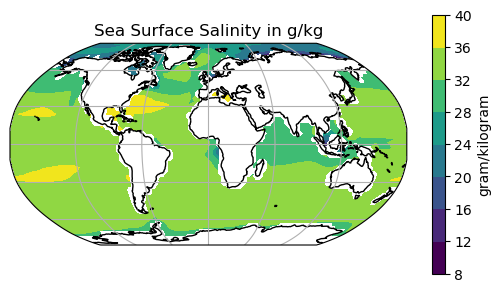

In [20]:
# fig = figure(figsize=(18, 16))
display(ClimatePlots.contourf(C; region="auto", titlestr="Sea Surface Salinity in g/kg"))

Yay! We have a plot... Albeit one that isn't yet responding to customization RE size, and other such parameters. But it's a start :)


<h2> Conclusion </h2> 

I'll stick to Python for the time being - at least until I'm confident with the data, the analyses and the visualisations. The process was much simpler, due mainly to the much greater degree of - at all levels - support available. It seems like the path of least resistence in the first instance, until such time as the extra speed offered by Julia is increasingly desired. 

Nonetheless, I will continue to explore Julia on the side, and build experience with the language :)